In [1]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon, Point
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
# import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors
import wandb
from typing import Optional, Union
from pathlib import Path
import orbax.checkpoint


# JAX
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'gpu')  # Use GPU

from jax import random, lax, jit, ops
from jax.example_libraries import stax
# previously was "from jax.experimental import stax" due to previous versions of jax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim
import random as rnd

# check versions
print(numpyro.__version__)
print(jax.__version__)
# print(torch.__version__)
from platform import python_version
print(python_version())

0.14.0
0.4.30
3.12.3


## Read shape files

In [2]:
# Set admin level
admin_level = 2

In [3]:
shape_new = gpd.read_file(f"data/Shapefiles/zmb_admbnda_adm{admin_level}_dmmu_20201124.shp")
shape_new = shape_new[[f"ADM{admin_level}_EN", 'geometry']]
shape_new['new'] = 1
shape_new

,ADM2_EN,geometry,new
0,Chibombo,"POLYGON ((28.00409 -14.51361, 28.00989 -14.514...",1
1,Chisamba,"POLYGON ((28.65022 -14.38920, 28.65131 -14.389...",1
2,Chitambo,"POLYGON ((29.99949 -12.00267, 30.00002 -12.002...",1
3,Itezhi-tezhi,"POLYGON ((26.99044 -15.46178, 27.20284 -15.468...",1
4,Kabwe,"POLYGON ((28.33593 -14.26089, 28.33684 -14.262...",1
...,...,...,...
110,Sioma,"POLYGON ((23.22303 -16.24968, 23.22304 -16.249...",1
111,Kapiri Mposhi,"POLYGON ((28.97528 -13.77728, 28.97804 -13.777...",1
112,Nchelenge,"POLYGON ((28.98384 -9.11358, 29.01004 -9.12788...",1
113,Shiwamg'andu,"POLYGON ((31.71596 -10.50328, 31.72146 -10.507...",1


<Axes: >

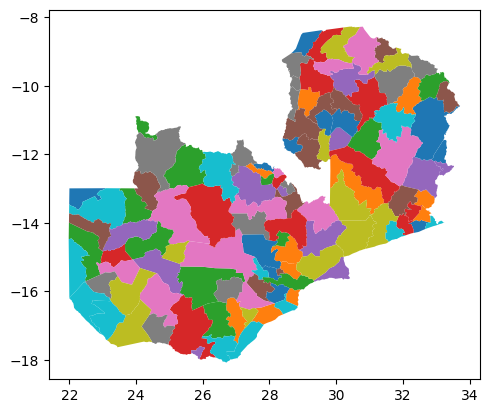

In [4]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
shape_new.plot(ax=ax, column=f"ADM{admin_level}_EN")

<Axes: >

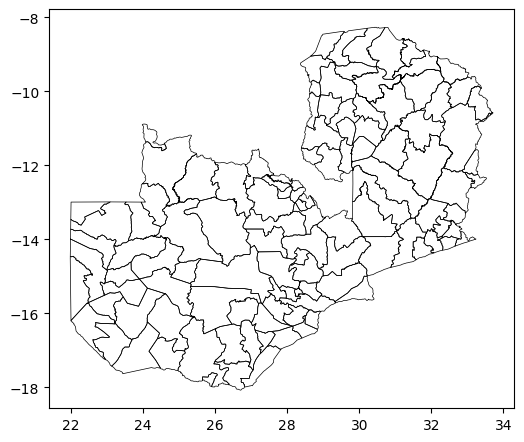

In [5]:
shape_new.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/boundaries_after2010.pdf')

In [6]:
# capitalise unit names
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
shape_new[f"ADM{admin_level}_EN"] =  np.array([names_shape_new[i].upper() for i in range(len(names_shape_new))])
shape_new.head(5)

,ADM2_EN,geometry,new
0,CHIBOMBO,"POLYGON ((28.00409 -14.51361, 28.00989 -14.514...",1
1,CHISAMBA,"POLYGON ((28.65022 -14.38920, 28.65131 -14.389...",1
2,CHITAMBO,"POLYGON ((29.99949 -12.00267, 30.00002 -12.002...",1
3,ITEZHI-TEZHI,"POLYGON ((26.99044 -15.46178, 27.20284 -15.468...",1
4,KABWE,"POLYGON ((28.33593 -14.26089, 28.33684 -14.262...",1


In [7]:
names_shape_new = shape_new[f"ADM{admin_level}_EN"].values
names_shape_new

array(['CHIBOMBO', 'CHISAMBA', 'CHITAMBO', 'ITEZHI-TEZHI', 'KABWE',
       'LUANO', 'MKUSHI', 'MUMBWA', 'NGABWE', 'SERENJE', 'CHILILABOMBWE',
       'CHINGOLA', 'KALULUSHI', 'KITWE', 'LUANSHYA', 'LUFWANYAMA',
       'MASAITI', 'MPONGWE', 'MUFULIRA', 'NDOLA', 'CHADIZA', 'CHASEFU',
       'CHIPANGALI', 'CHIPATA', 'KASENENGWA', 'KATETE', 'LUMEZI',
       'LUNDAZI', 'MAMBWE', 'NYIMBA', 'PETAUKE', 'SINDA', 'VUBWI',
       'CHEMBE', 'CHIENGI', 'CHIFUNABULI', 'CHIPILI', 'KAWAMBWA', 'LUNGA',
       'MANSA', 'MILENGI', 'MWANSABOMBWE', 'MWENSE', 'SAMFYA', 'CHILANGA',
       'CHIRUNDU', 'CHONGWE', 'KAFUE', 'LUANGWA', 'LUSAKA', 'RUFUNSA',
       'SHIBUYUNJI', 'CHAMA', 'CHINSALI', 'ISOKA', 'KANCHIBIYA',
       'LAVUSHIMANDA', 'MAFINGA', 'MPIKA', 'NAKONDE', 'CHAVUMA',
       'IKELENGE', 'KABOMPO', 'KALUMBILA', 'KASEMPA', 'MANYINGA',
       'MUFUMBWE', 'MUSHINDANO', 'MWINILUNGA', 'SOLWEZI', 'ZAMBEZI',
       'CHILUBI', 'KAPUTA', 'KASAMA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUWINGU', 'MBALA', 'MPU

# Malaria data

In [8]:
infections_new = pd.read_csv(f"../../data/dhs/ZMB_prev_data_admin{admin_level}.csv")
infections_new = infections_new[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_new = infections_new.rename({'unit': 'area'}, axis='columns')
infections_new = infections_new.sort_values(by=['area'])
infections_new.head(5)

,area,usage,num_rdt,num_rdt_positive,prev_estimate
0,Chadiza,0.592593,43.522101,2.352546,0.054054
1,Chama,0.656690,219.745559,13.109616,0.059658
2,Chasefu,0.491268,157.033307,2.872475,0.018292
3,Chavuma,0.438596,56.444920,5.039725,0.089286
4,Chembe,0.826087,50.954995,0.000000,0.000000


## Merge infections and shape

In [9]:
if (admin_level==2):
    # Create new rows with zero values
    new_rows = pd.DataFrame({'area': ['CHIRUNDU', 'ITEZHI-TEZHI', 'SHIBUYUNJI'],
                             'usage': [0.0, 0.0, 0.0],
                             'num_rdt': [0.0, 0.0, 0.0],
                             'num_rdt_positive': [0.0, 0.0, 0.0],
                             'prev_estimate': [0.0, 0.0, 0.0]})

    # Append new rows to infections_new
    infections_new = pd.concat([infections_new, new_rows])

In [10]:
names_infections_new = infections_new.area.values
shape_new = shape_new.rename({f"ADM{admin_level}_EN": 'area'}, axis='columns')
shape_new = shape_new.sort_values(by=['area'])
shape_new.head(3)
names_shape_new = shape_new['area'].values
print(names_infections_new)
print(names_shape_new)

['Chadiza' 'Chama' 'Chasefu' 'Chavuma' 'Chembe' 'Chibombo' 'Chiengi'
 'Chifunabuli' 'Chikankanta' 'Chilanga' 'Chililabombwe' 'Chilubi'
 'Chingola' 'Chinsali' 'Chipangali' 'Chipata' 'Chipili' 'Chisamba'
 'Chitambo' 'Choma' 'Chongwe' 'Gwembe' 'Ikelenge' 'Isoka' 'Kabompo'
 'Kabwe' 'Kafue' 'Kalabo' 'Kalomo' 'Kalulushi' 'Kalumbila' 'Kanchibiya'
 'Kaoma' 'Kapiri Mposhi' 'Kaputa' 'Kasama' 'Kasempa' 'Kasenengwa' 'Katete'
 'Kawambwa' 'Kazungula' 'Kitwe' 'Lavushimanda' 'Limulunga' 'Livingstone'
 'Luampa' 'Luangwa' 'Luano' 'Luanshya' 'Lufwanyama' 'Lukulu' 'Lumezi'
 'Lundazi' 'Lunga' 'Lunte District' 'Lupososhi' 'Lusaka' 'Luwingu'
 'Mafinga' 'Mambwe' 'Mansa' 'Manyinga' 'Masaiti' 'Mazabuka' 'Mbala'
 'Milengi' 'Mitete' 'Mkushi' 'Mongu' 'Monze' 'Mpika' 'Mpongwe' 'Mporokoso'
 'Mpulungu' 'Mufulira' 'Mufumbwe' 'Mulobezi' 'Mumbwa' 'Mungwi'
 'Mushindano' 'Mwandi' 'Mwansabombwe' 'Mwense' 'Mwinilunga' 'Nakonde'
 'Nalolo' 'Namwala' 'Nchelenge' 'Ndola' 'Ngabwe' 'Nkeyema' 'Nsama'
 'Nyimba' 'Pemba' 'Petauke' 'R

In [11]:
# Re-labelling for admin level 1
if (admin_level==1):
    names_infections_new[6] = 'North-Western'
# convert to uppercase
names_infections_new = [names_infections_new[i].upper() for i in range(len(names_infections_new))]
print(names_infections_new)
print(names_shape_new)

['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO', 'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA', 'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI', 'CHIPATA', 'CHIPILI', 'CHISAMBA', 'CHITAMBO', 'CHOMA', 'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI', 'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA', 'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA', 'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE', 'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU', 'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI', 'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA', 'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI', 'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU', 'MUFULIRA', 'MUFUMBWE', 'MULOBEZI', 'MUMBWA', 'MUNGWI', 'MUSHINDANO', 'MWANDI', 'MWANSABOMBWE', 'MWENSE', 'MWINILUNGA', 'NAKONDE', 'NALOLO', 'NAMWALA', 'NC

In [12]:
names_shape_new_lst = list(names_shape_new)
lst = [names_shape_new_lst[i] not in names_infections_new for i in range(len(names_shape_new))]
[names_shape_new_lst[i] for i in range(len(lst)) if lst[i] == True]

[]

In [13]:
names_infections_lst = list(names_infections_new)
lst2 = [names_infections_lst[i] not in names_shape_new for i in range(len(names_infections_new))]
[names_infections_lst[i] for i in range(len(lst2)) if lst2[i] == True]

[]

In [14]:
names_infections_new

['CHADIZA',
 'CHAMA',
 'CHASEFU',
 'CHAVUMA',
 'CHEMBE',
 'CHIBOMBO',
 'CHIENGI',
 'CHIFUNABULI',
 'CHIKANKANTA',
 'CHILANGA',
 'CHILILABOMBWE',
 'CHILUBI',
 'CHINGOLA',
 'CHINSALI',
 'CHIPANGALI',
 'CHIPATA',
 'CHIPILI',
 'CHISAMBA',
 'CHITAMBO',
 'CHOMA',
 'CHONGWE',
 'GWEMBE',
 'IKELENGE',
 'ISOKA',
 'KABOMPO',
 'KABWE',
 'KAFUE',
 'KALABO',
 'KALOMO',
 'KALULUSHI',
 'KALUMBILA',
 'KANCHIBIYA',
 'KAOMA',
 'KAPIRI MPOSHI',
 'KAPUTA',
 'KASAMA',
 'KASEMPA',
 'KASENENGWA',
 'KATETE',
 'KAWAMBWA',
 'KAZUNGULA',
 'KITWE',
 'LAVUSHIMANDA',
 'LIMULUNGA',
 'LIVINGSTONE',
 'LUAMPA',
 'LUANGWA',
 'LUANO',
 'LUANSHYA',
 'LUFWANYAMA',
 'LUKULU',
 'LUMEZI',
 'LUNDAZI',
 'LUNGA',
 'LUNTE DISTRICT',
 'LUPOSOSHI',
 'LUSAKA',
 'LUWINGU',
 'MAFINGA',
 'MAMBWE',
 'MANSA',
 'MANYINGA',
 'MASAITI',
 'MAZABUKA',
 'MBALA',
 'MILENGI',
 'MITETE',
 'MKUSHI',
 'MONGU',
 'MONZE',
 'MPIKA',
 'MPONGWE',
 'MPOROKOSO',
 'MPULUNGU',
 'MUFULIRA',
 'MUFUMBWE',
 'MULOBEZI',
 'MUMBWA',
 'MUNGWI',
 'MUSHINDANO',
 'MWAN

In [15]:
infections_new.area = names_infections_new
infections_new

,area,usage,num_rdt,num_rdt_positive,prev_estimate
0,CHADIZA,0.592593,43.522101,2.352546,0.054054
1,CHAMA,0.656690,219.745559,13.109616,0.059658
2,CHASEFU,0.491268,157.033307,2.872475,0.018292
3,CHAVUMA,0.438596,56.444920,5.039725,0.089286
4,CHEMBE,0.826087,50.954995,0.000000,0.000000
...,...,...,...,...,...
110,ZAMBEZI,0.729241,121.081102,1.686360,0.013928
111,ZIMBA,0.542139,89.358756,9.592446,0.107348
0,CHIRUNDU,0.000000,0.000000,0.000000,0.000000
1,ITEZHI-TEZHI,0.000000,0.000000,0.000000,0.000000


In [16]:
shape_new = shape_new.merge(infections_new, how='left', left_on='area', right_on='area')
shape_new.head(3)

,area,geometry,new,usage,num_rdt,num_rdt_positive,prev_estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,43.522101,2.352546,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,219.745559,13.109616,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157.033307,2.872475,0.018292


In [17]:
np.sum(np.isnan(shape_new.num_rdt))

0

In [18]:
s_new = shape_new.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_new['y'] = round(s_new['y']).astype(int)
s_new['n_obs'] = round(s_new['n_obs']).astype(int)
s_new.head(3)

,area,geometry,new,usage,n_obs,y,estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292


In [19]:
s_new_plot = shape_new.rename({'num_rdt': 'Total observations', 'num_rdt_positive': 'Positive test count', 'prev_estimate': 'Prevalence estimate'}, axis='columns')

In [20]:
s_new_plot

,area,geometry,new,usage,Total observations,Positive test count,Prevalence estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,43.522101,2.352546,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,219.745559,13.109616,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157.033307,2.872475,0.018292
3,CHAVUMA,"POLYGON ((21.99573 -13.46393, 21.99610 -13.439...",1,0.438596,56.444920,5.039725,0.089286
4,CHEMBE,"POLYGON ((28.89259 -11.50817, 28.87754 -11.520...",1,0.826087,50.954995,0.000000,0.000000
...,...,...,...,...,...,...,...
110,SIOMA,"POLYGON ((23.22303 -16.24968, 23.22304 -16.249...",1,0.740689,47.863205,5.892910,0.123120
111,SOLWEZI,"POLYGON ((26.54644 -11.95768, 26.55784 -11.971...",1,0.428974,407.405644,17.259948,0.042366
112,VUBWI,"POLYGON ((32.93181 -13.86676, 32.94124 -13.874...",1,0.620205,120.844356,3.945904,0.032653
113,ZAMBEZI,"POLYGON ((23.51068 -13.06689, 23.52472 -13.068...",1,0.729241,121.081102,1.686360,0.013928


In [120]:
s_new_plot

,area,geometry,new,usage,n_obs,y,estimate,gp_aggr_0,gp_aggr_1,gp_aggr_2,gp_aggr_3,gp_aggr_4,vae_draw_0,vae_draw_1,vae_draw_2,vae_draw_3,vae_draw_4
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054,-1.594230,1.105055,-0.098163,-0.059655,-0.870424,1.621324,3.351568,1.177425,-0.621984,1.208612
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658,0.780558,5.506135,3.373087,-0.683751,-0.846463,3.969715,3.008335,1.411494,1.230706,-1.301810
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292,-3.702009,3.838885,3.277968,-0.463953,-0.734036,2.088130,3.021351,2.340807,0.762531,-0.544516
3,CHAVUMA,"POLYGON ((21.99573 -13.46393, 21.99610 -13.439...",1,0.438596,56,5,0.089286,-1.565122,-0.795718,1.647239,-0.120853,1.162266,-0.460077,2.173341,0.943960,2.084614,-0.821396
4,CHEMBE,"POLYGON ((28.89259 -11.50817, 28.87754 -11.520...",1,0.826087,51,0,0.000000,-8.334169,-1.774438,-1.793157,-1.493381,2.423528,-0.774217,-1.581507,3.721083,-2.280209,-0.300314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,SIOMA,"POLYGON ((23.22303 -16.24968, 23.22304 -16.249...",1,0.740689,48,6,0.123120,-1.717211,-1.062184,1.834562,-1.427858,1.087657,0.249682,1.555518,-0.963303,0.115071,-0.786835
111,SOLWEZI,"POLYGON ((26.54644 -11.95768, 26.55784 -11.971...",1,0.428974,407,17,0.042366,-2.339724,-4.023777,2.859578,1.420810,-0.663479,-3.315569,-0.357152,-1.700165,-3.281580,-0.570044
112,VUBWI,"POLYGON ((32.93181 -13.86676, 32.94124 -13.874...",1,0.620205,121,4,0.032653,-2.206766,1.318594,0.625965,-0.464705,-1.662888,1.479020,3.112022,1.321313,-0.215899,1.304751
113,ZAMBEZI,"POLYGON ((23.51068 -13.06689, 23.52472 -13.068...",1,0.729241,121,2,0.013928,-0.329869,-1.446701,2.551700,2.239466,1.756850,-1.056931,2.571949,1.123126,2.579215,-0.974294


In [123]:
s_sort = s_new_plot.sort_values(by=['estimate'], ascending=False)
s_sort.head(10)

,area,geometry,new,usage,n_obs,y,estimate,gp_aggr_0,gp_aggr_1,gp_aggr_2,gp_aggr_3,gp_aggr_4,vae_draw_0,vae_draw_1,vae_draw_2,vae_draw_3,vae_draw_4
82,MWANDI,"POLYGON ((25.15549 -17.02074, 25.15434 -17.024...",1,0.555556,22,6,0.257143,-1.293298,1.726373,-0.412053,1.276913,-0.787879,1.523516,3.095438,0.640668,-0.303636,0.065513
88,NAMWALA,"POLYGON ((26.95714 -15.57718, 26.97054 -15.588...",1,0.474592,129,29,0.228829,-4.881499,0.827065,1.871951,1.883572,-0.342097,-0.218538,0.179486,-0.382759,-0.360201,0.081697
106,SIAVONGA,"POLYGON ((28.49670 -16.06598, 28.50110 -16.066...",1,0.531275,78,17,0.215859,-2.536767,-0.960789,1.985418,-0.264553,0.360178,-3.130111,-0.326097,0.217516,0.511665,0.211481
45,LIMULUNGA,"POLYGON ((23.66967 -14.68601, 23.67304 -14.826...",1,0.752348,58,12,0.200730,-1.230407,-1.612376,0.620386,-1.714826,2.268077,0.329873,1.825630,0.622734,1.959658,-1.639401
46,LIVINGSTONE,"POLYGON ((25.90754 -17.98358, 25.90464 -17.980...",1,0.506488,544,109,0.199494,-6.283161,2.322928,0.298952,-0.084150,-2.878723,1.560472,3.957710,-0.308891,0.385149,1.028639
8,CHIKANKANTA,"POLYGON ((28.04894 -15.76218, 28.06214 -15.763...",1,0.287359,56,10,0.187045,-3.674070,-1.064746,1.820802,0.814799,0.341460,-3.442078,-0.770456,-0.363766,0.141016,-0.158956
9,CHILANGA,"POLYGON ((27.99276 -15.30419, 27.99314 -15.304...",1,0.348646,320,56,0.174868,-3.587971,-1.259934,2.069010,-0.396673,-0.075437,-3.221854,-1.313998,-1.062992,-0.487974,-0.273843
65,MAZABUKA,"POLYGON ((27.61591 -15.52350, 27.61987 -15.524...",1,0.462473,306,46,0.150526,-3.081538,-0.436630,2.765285,0.595117,0.003686,-2.351825,-0.941584,-0.432044,-0.058669,-0.165488
102,SESHEKE,"POLYGON ((24.12034 -16.23433, 24.45789 -16.539...",1,0.537177,40,6,0.149886,-3.776104,0.644624,1.240041,0.495398,0.568647,1.217057,2.571110,0.119121,-0.150601,-0.302902
50,LUANSHYA,"POLYGON ((28.37098 -12.93364, 28.37974 -12.955...",1,0.355441,271,40,0.149392,-0.470803,-2.388763,-1.380661,-1.423347,1.890951,-2.365738,-0.813817,1.721358,-1.158215,0.125734


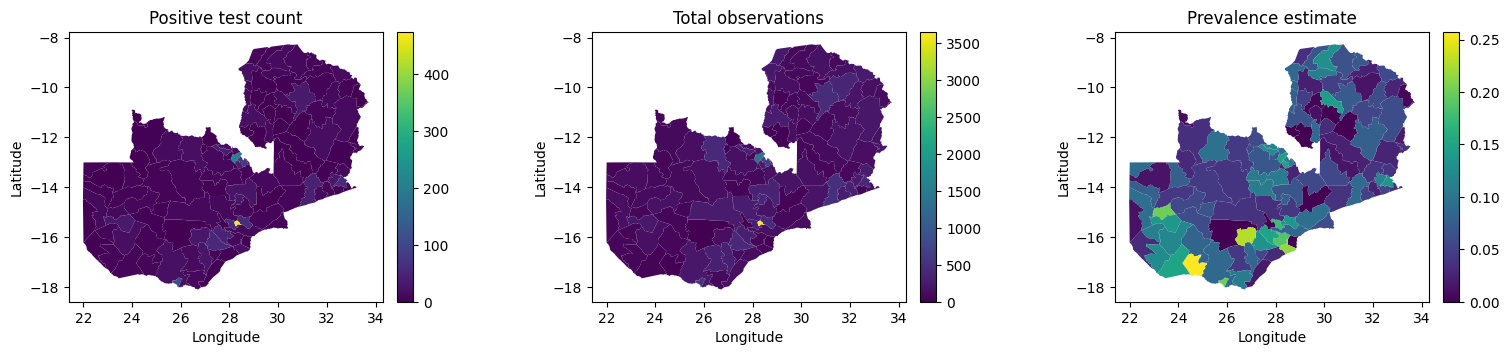

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot the data with a consistent colorbar size
for i, column in enumerate(["Positive test count", "Total observations", "Prevalence estimate"]):
    plot = s_new_plot.plot(column=column, ax=ax[i], legend=False)
    ax[i].set_title(column)
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
    
    # Create an axis on the right side of the plot for the colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    # Create colorbar using the first collection's norm and cmap
    sm = plt.cm.ScalarMappable(cmap=plot.collections[0].cmap, norm=plot.collections[0].norm)
    sm._A = []  # Dummy array for the scalar mappable
    fig.colorbar(sm, cax=cax)

# Adjust space between plots
plt.subplots_adjust(wspace=0.5)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Save the figure as a PDF
plt.savefig(f'figures/ZMB2018_{admin_level}_observations.pdf')

In [22]:
if (admin_level==2):
    # Check y and n_obs for capital, Lusaka
    lusaka_data = s_new[s_new['area'] == 'LUSAKA']
    print(lusaka_data[['y', 'n_obs']])

      y  n_obs
58  474   3653


In [23]:
del shape_new
del infections_new

## Computational grid

In [24]:
x_min, x_max, y_min, y_max = 21.5, 34, -19, -8
dy = y_max - y_min
dx = x_max - x_min
factor = dy / dx
n_x = 40 
n_y = math.ceil(n_x * factor)
print(n_x)
print(n_y)
print(n_x * n_y)

x_grid = np.linspace(x_min, x_max, n_x, endpoint=True)
y_grid = np.linspace(y_min, y_max, n_y, endpoint=True)

# full coordinate arrays
x_coords, y_coords = np.meshgrid(x_grid, y_grid)
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

df = pd.DataFrame({'Latitude': y_coords, 'Longitude': x_coords})

grid_pts = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

x = jnp.array([x_coords, y_coords]).transpose((1, 0))
print(x.shape)

40
36
1440
(1440, 2)


2024-07-11 10:22:23.206234: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [25]:
xtest = np.tile(x, (12, 1, 1))
xtest.shape

(12, 1440, 2)

<Axes: >

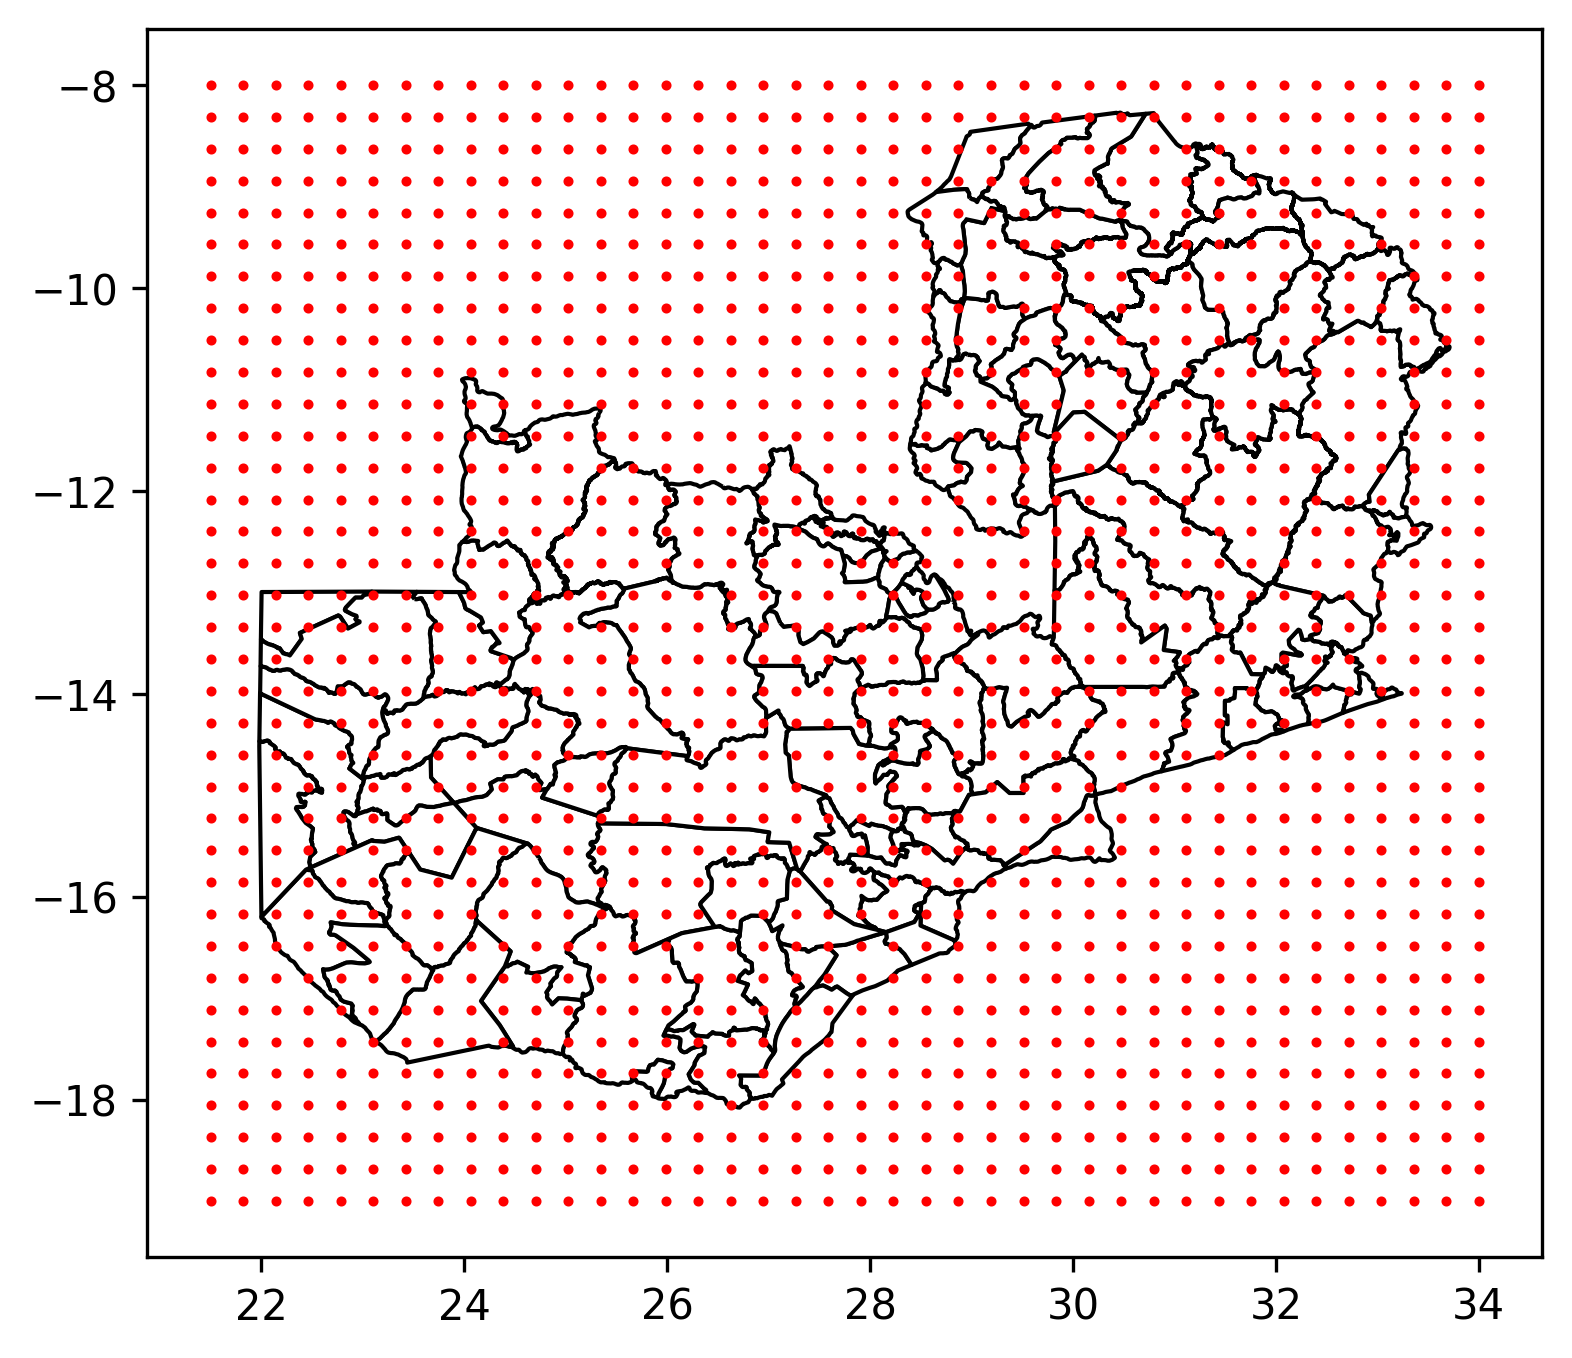

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s_new.plot(ax=ax, color='white', edgecolor='black')
grid_pts.plot(ax=ax, marker='o', color='red', markersize=2)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/comp_grid.pdf')

In [27]:
def pol_pts(shape, grid_pts, min_pts=10):
    grid_pts.set_crs(epsg=4326, inplace=True);
    grid_pts.crs == shape.crs

    n_pol = len(shape.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)

    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol in range(n_pol):
        pol = shape.geometry[i_pol]
        for j_pts in range(n_pts):
            pt = grid_pts.geometry[j_pts]
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!


    # ensure a minimum number of points

    pol_sums = np.sum(pl_pt, axis=1)

    fix_pols = np.where(pol_sums<min_pts)[0]

    if fix_pols.size > 0:

      for i_pol in fix_pols:

        # print(f'i_pol:{i_pol}')

        polygon = shape.geometry[i_pol]
        no_points = pol_sums[i_pol]

        extra_len = min_pts - no_points
        minx, miny, maxx, maxy = polygon.bounds
        extra_y_coords = []
        extra_x_coords = []

        main_rng_key = random.PRNGKey(44)

        # print(extra_len)

        while extra_len > 0:
            main_rng_key, rng_key_pts = random.split(main_rng_key)
            random_point_coords = [
                random.uniform(rng_key_pts, (1,), minval=minx, maxval=maxx)[0],
                random.uniform(rng_key_pts, (1,), minval=miny, maxval=maxy)[0]
            ]
            random_point = Point(float(random_point_coords[0]), float(random_point_coords[1]))

            if polygon.contains(random_point):
              # print('Contains random point')
              extra_y_coords.append(random_point.y)
              extra_x_coords.append(random_point.x)
              extra_len -= 1

        # add extra points to grid

        # Create DataFrame for new points
        extra_df = pd.DataFrame({'Latitude': extra_y_coords, 'Longitude': extra_x_coords})
        extra_grid_pts = gpd.GeoDataFrame(extra_df, geometry=gpd.points_from_xy(extra_df.Longitude, extra_df.Latitude))

        # Set CRS for the new GeoDataFrame
        extra_grid_pts.set_crs(epsg=4326, inplace=True)

        # Concatenate the original and new GeoDataFrames
        grid_pts = pd.concat([grid_pts, extra_grid_pts]).reset_index(drop=True)


      # Amend pl_pt and pt_which_pol (outside polygon loop)
      pl_pt, pt_which_pol, _ = pol_pts(shape, grid_pts, min_pts)

    return([pl_pt, pt_which_pol, grid_pts])

In [28]:
pol_pt_new, pt_which_pol_new, grid_pts_new = pol_pts(s_new, grid_pts, min_pts=10)
pol_sums_new = np.sum(pol_pt_new, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_new)) # in each polygon there is at least one point
print(all(item >= 10 for item in pol_sums_new)) # in each polygon there is at least 10 points
grid_pts_new['pt_which_pol_new'] = pt_which_pol_new
grid_pts_new

True


,Latitude,Longitude,geometry,pt_which_pol_new
0,-19.000000,21.500000,POINT (21.50000 -19.00000),0
1,-19.000000,21.820513,POINT (21.82051 -19.00000),0
2,-19.000000,22.141026,POINT (22.14103 -19.00000),0
3,-19.000000,22.461538,POINT (22.46154 -19.00000),0
4,-19.000000,22.782051,POINT (22.78205 -19.00000),0
...,...,...,...,...
2013,-17.455769,26.790142,POINT (26.79014 -17.45577),115
2014,-17.507141,26.722168,POINT (26.72217 -17.50714),115
2015,-17.777426,26.364519,POINT (26.36452 -17.77743),115
2016,-17.394756,26.870876,POINT (26.87088 -17.39476),115


In [29]:
pol_pt_new.shape

(115, 2018)

In [30]:
pol_sums_new

array([10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 18, 10, 10, 10, 13, 10, 13, 10, 10, 10, 10, 11, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 13, 10, 10, 10, 10, 15, 10, 18, 10, 10, 10, 10, 10,
       17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 12, 10])

In [31]:
new_y_coords = grid_pts_new['Latitude']
new_x_coords = grid_pts_new['Longitude']
new_x = jnp.array([new_x_coords, new_y_coords]).transpose((1, 0))
print(new_x.shape)

(2018, 2)


In [32]:
grid_pts = grid_pts_new
grid_pts.shape

(2018, 4)

In [33]:
grid_pts['in_out_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 1 if x==0 else 12)
n_pol_new = len(s_new.geometry)

In [34]:
cmap = plt.cm.prism  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

<Axes: >

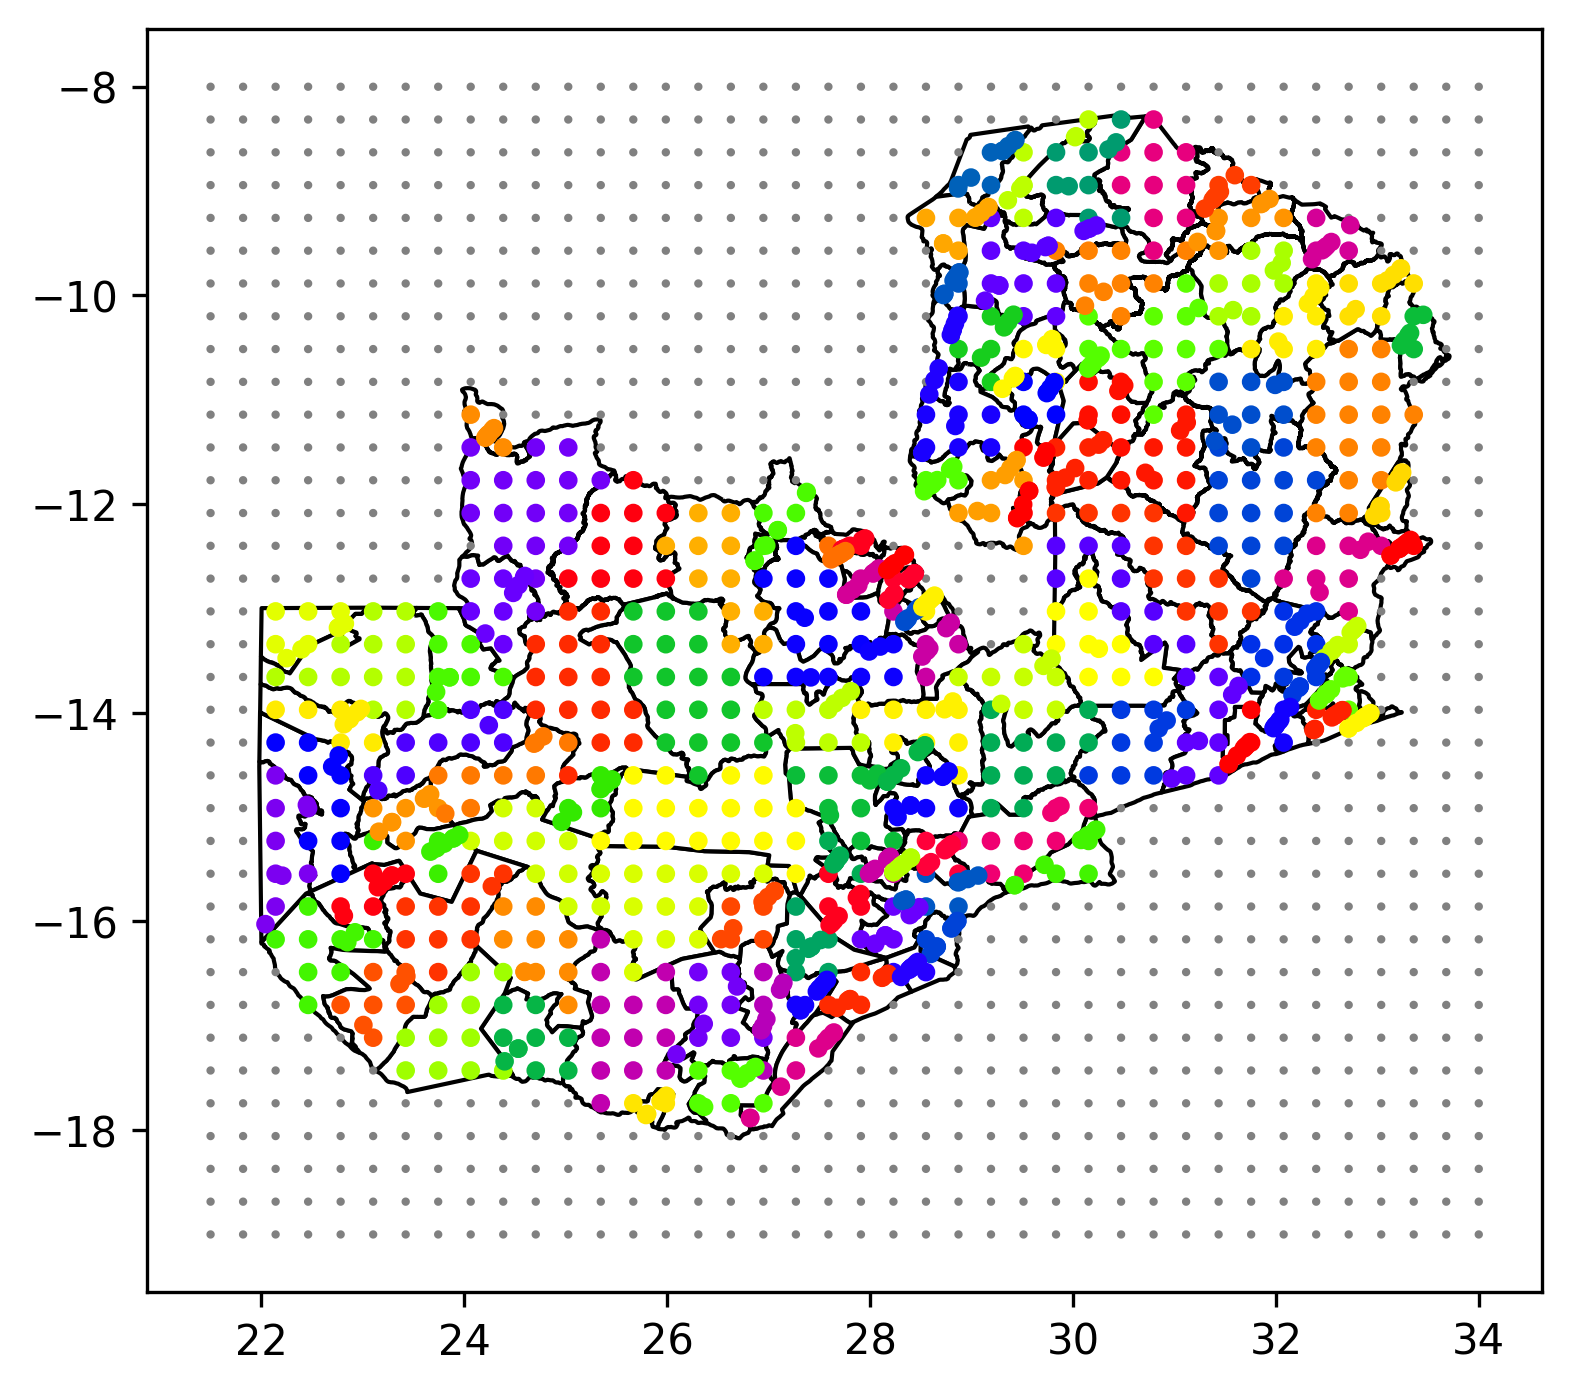

In [35]:
fig, ax2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)
#ax2.title.set_text('After 2010')

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/grid_polygons_after.pdf')

In [36]:
s_new.head(3)

,area,geometry,new,usage,n_obs,y,estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292


In [37]:
type(s_new)

geopandas.geodataframe.GeoDataFrame

In [38]:
s = s_new.rename({'Total observations':'n_obs', 'Positive tests count':'y', 'Prevalence estimate':'estimate'}, axis='columns')
# s = pd.concat([s_old, s_new])
s.head()
#print(s.shape)

,area,geometry,new,usage,n_obs,y,estimate
0,CHADIZA,"POLYGON ((32.57804 -13.93448, 32.75563 -13.982...",1,0.592593,44,2,0.054054
1,CHAMA,"POLYGON ((32.84411 -10.34120, 32.84790 -10.341...",1,0.656690,220,13,0.059658
2,CHASEFU,"POLYGON ((32.94614 -12.21183, 32.94578 -12.211...",1,0.491268,157,3,0.018292
3,CHAVUMA,"POLYGON ((21.99573 -13.46393, 21.99610 -13.439...",1,0.438596,56,5,0.089286
4,CHEMBE,"POLYGON ((28.89259 -11.50817, 28.87754 -11.520...",1,0.826087,51,0,0.000000


# Traditional prevalence model

In [39]:
# draw GP samples on the grid

def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [40]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

## CVAE architecture

In [41]:
from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm

In [89]:
args = {"seed": 0,

        # architecture
        "conditional": True,
        "input_dim": 80,
        "hidden_dim": 60,
        "z_dim": 40,

        # data generation
        "new_data": True,  # set to True to generate new data. Otherwise read from file
        "save_data": False, # set to True to save generated training and test datasets
        "batch_size": 100,
        "samples": 5000,

        # VAE setup
        "vae_sd": 1,
        "n_epochs": 50,        # for better results, set to 15000
        "learning_rate": 1e-3,
        "train_vae": True,      # set to True to train VAE
        "save_vae": False,
        "load_vae": False,      # set to True to load trained CVAE
        "decoder_params": None,
        "hyperprior_ls_name": "InverseGamma(3, 3)",
        "hyperprior_var_name": "HalfNormal(0.05)",
        "hyperprior_ls": dist.InverseGamma(3, 3),
        "hyperprior_var": dist.HalfNormal(0.05),

        # MCMC setup
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
        "true_ls": 0.2,

        'n_obs': jnp.array(s.n_obs),
        "x": new_x,
        "gp_kernel": exp_sq_kernel,
        "jitter": 1e-4,
        "M_new": pol_pt_new,

        # VAE training
        "rng_key": random.PRNGKey(5),
        
        # posterior analysis
        "num_samples_posterior": 100,
       }

In [90]:
model_specs = '_n'+(str(args["input_dim"])+
            '_h'+str(args["hidden_dim"])+
            '_z'+str(args["z_dim"])+
            '_epochs'+str(args["n_epochs"])+
            '_ls' + args['hyperprior_ls_name']+
            '_var' + args['hyperprior_var_name'])
print('Model specifications:', model_specs)

Model specifications: _n80_h60_z40_epochs50_lsInverseGamma(3, 3)_varHalfNormal(0.05)


In [91]:
from collections.abc import Callable
from flax import linen as nn


class MLP(nn.Module):
    dims: list[int]
    act_fn: Callable = nn.relu
    p_dropout: float = 0.0

    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.dims[:-1]:
            x = nn.Dense(dim)(x)
            x = self.act_fn(x)
            x = nn.Dropout(self.p_dropout, deterministic=not training)(x)
        return nn.Dense(self.dims[-1])(x)

In [92]:
#!/usr/bin/env python3
import jax.numpy as jnp
from flax import linen as nn
from jax import Array, random


class PriorCVAE(nn.Module):
    r"""[PriorCVAE](https://arxiv.org/pdf/2304.04307) approximates a Gaussian Process.

    Once trained, the module's `decoder` can be used as a generative
    model to simulate a GP from the samples it was trained on.

    Args:
        encoder: A module used to encode GP realizations and
            their hyperparamters.
        decoder: A module used to decode random vectors and
            GP hyperparameters into GP samples.
        z_dim: The size of the hidden dimension.

    Returns:
        An instance of the PriorCVAE network.
        $\hat{\mathbf{f}}$, a recreation of the original $\mathbf{f}$,
        along with $\mu$ and $\log(\sigma^2)$, which are often used
        to calculate losses involving KL divergence.
    """

    encoder: nn.Module
    decoder: nn.Module
    z_dim: int

    @nn.compact
    def __call__(self, rng: Array, var: float, ls: float, f: Array):
        r"""Run module forward.

        Args:
            rng: A pseudo-random number generator.
            var: The variance for the GP.
            ls: The lengthscale for the GP.
            f: The function values, an array of shape `(B, K, 1)`.

        Returns:
            $\hat{\mathbf{f}}$, a recreation of the original$\mathbf{f}$,
            along with $\mu$ and $\log(\sigma^2)$, which are often used
            to calculate losses involving KL divergence.
        """
        batch_size = f.shape[0]
        var = jnp.full((batch_size, 1), var)
        ls = jnp.full((batch_size, 1), ls)
        f_flat = f.reshape(batch_size, -1)
        latents = self.encoder(jnp.hstack([f_flat, var, ls]))
        mu = nn.Dense(self.z_dim)(latents)
        log_var = nn.Dense(self.z_dim)(latents)
        std = jnp.exp(log_var / 2)
        eps = random.normal(rng, log_var.shape)
        z = mu + std * eps
        f_hat = self.decoder(jnp.hstack([z, var, ls]))
        return f_hat.reshape(f.shape), mu, log_var
    
    def decode(self, z: Array, var: float, ls: float):
        B = z.shape[0]
        var = jnp.full((B, 1), var)
        ls = jnp.full((B, 1), ls)
        return self.decoder(jnp.hstack([z, var, ls]))

In [93]:
def build_prior_cvae(num_s: int = 64, z_dim: int = 64, hidden_dim: int = 128):
    encoder = MLP([hidden_dim, z_dim])
    decoder = MLP([hidden_dim, num_s])
    return PriorCVAE(encoder, decoder, z_dim)

In [94]:
def gp_aggr(args):

    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", args['hyperprior_ls'])
    variance = numpyro.sample("kernel_var", args['hyperprior_var'])
    k = gp_kernel(x, x, variance, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', gp_aggr_new)
    ls = numpyro.deterministic('ls', length)
    var = numpyro.deterministic('var', variance)

In [95]:
# aggGP: prior predictive
rng_key, rng_key_ = random.split(random.PRNGKey(4))
agg_gp_predictive = Predictive(gp_aggr, num_samples=args['num_samples_posterior'])
agg_gp_preds = agg_gp_predictive(rng_key_, args)
agg_gp_draws = agg_gp_preds['gp_aggr_new']
ls_draws = agg_gp_preds['ls']
var_draws = jnp.array(agg_gp_preds['var'])

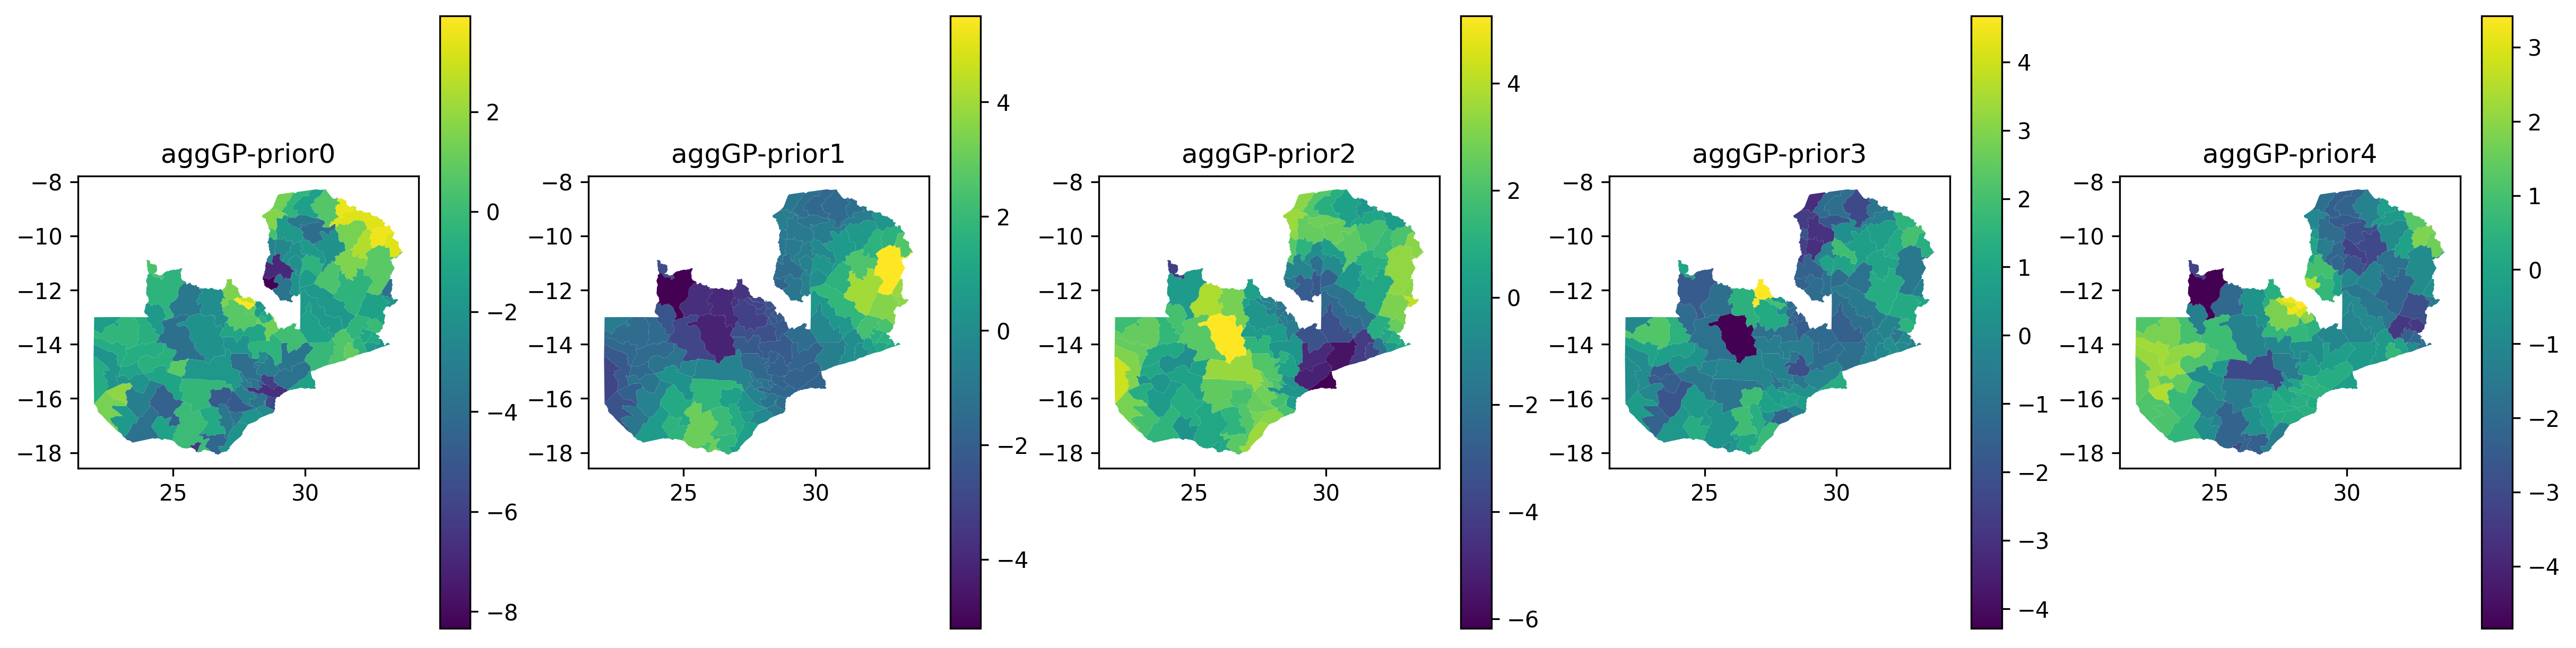

In [96]:
s_new_plot = s.copy()

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_aggr_' + str(i)
    # s_new_plot[nm] = agg_gp_draws[i,n_old:(n_old + n_new)]
    s_new_plot[nm] = agg_gp_draws[i,:]
    s_new_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'aggGP-prior' + str(i))

In [97]:
# have to add number of epochs in training so that the name is relevant
model_save_name = f'AggCVAE_admin{admin_level}_decoder' + model_specs
PATH = F"decoders/{model_save_name}"
PATH_loss = F"losses/{model_save_name}"

In [98]:
# Load
with open(PATH, 'rb') as file:
   decoder_params = pickle.load(file)
   print(len(decoder_params))

args["decoder_params"] = decoder_params

2


In [99]:
with open(PATH_loss, 'rb') as file:
   losses_save = pickle.load(file)

train_losses_save = losses_save['train_losses']
val_losses_save = losses_save['val_losses']

print(losses_save)

{'train_losses': array([4.25159979, 2.97857022, 2.63867116, 2.45710683, 2.34514236,
       2.2689786 , 2.21462917, 2.16785479, 2.13193989, 2.1045258 ,
       2.07294583, 2.04683256, 2.02459717, 2.00352478, 1.98497498,
       1.96900845, 1.95214224, 1.93573761, 1.92073679, 1.90412807,
       1.89424908, 1.87984705, 1.86791742, 1.85706282, 1.84881115,
       1.84104323, 1.82771897, 1.82013762, 1.81174743, 1.80638695,
       1.80012345, 1.79231477, 1.78536999, 1.7805655 , 1.77578461,
       1.7722218 , 1.76535988, 1.76215756, 1.7599591 , 1.75521803,
       1.75032997, 1.74650788, 1.74340296, 1.73861039, 1.73921943,
       1.73356605, 1.73155165, 1.72997081, 1.72876906, 1.72248971]), 'val_losses': array([3.18490624, 2.77114844, 2.54261541, 2.4004972 , 2.3406837 ,
       2.27197146, 2.23147726, 2.18892527, 2.15063477, 2.14305544,
       2.1019721 , 2.05302835, 2.05042553, 2.05419183, 2.02854753,
       1.98816144, 1.9956398 , 1.9750737 , 1.97623169, 1.93794036,
       1.92230606, 1.92581868

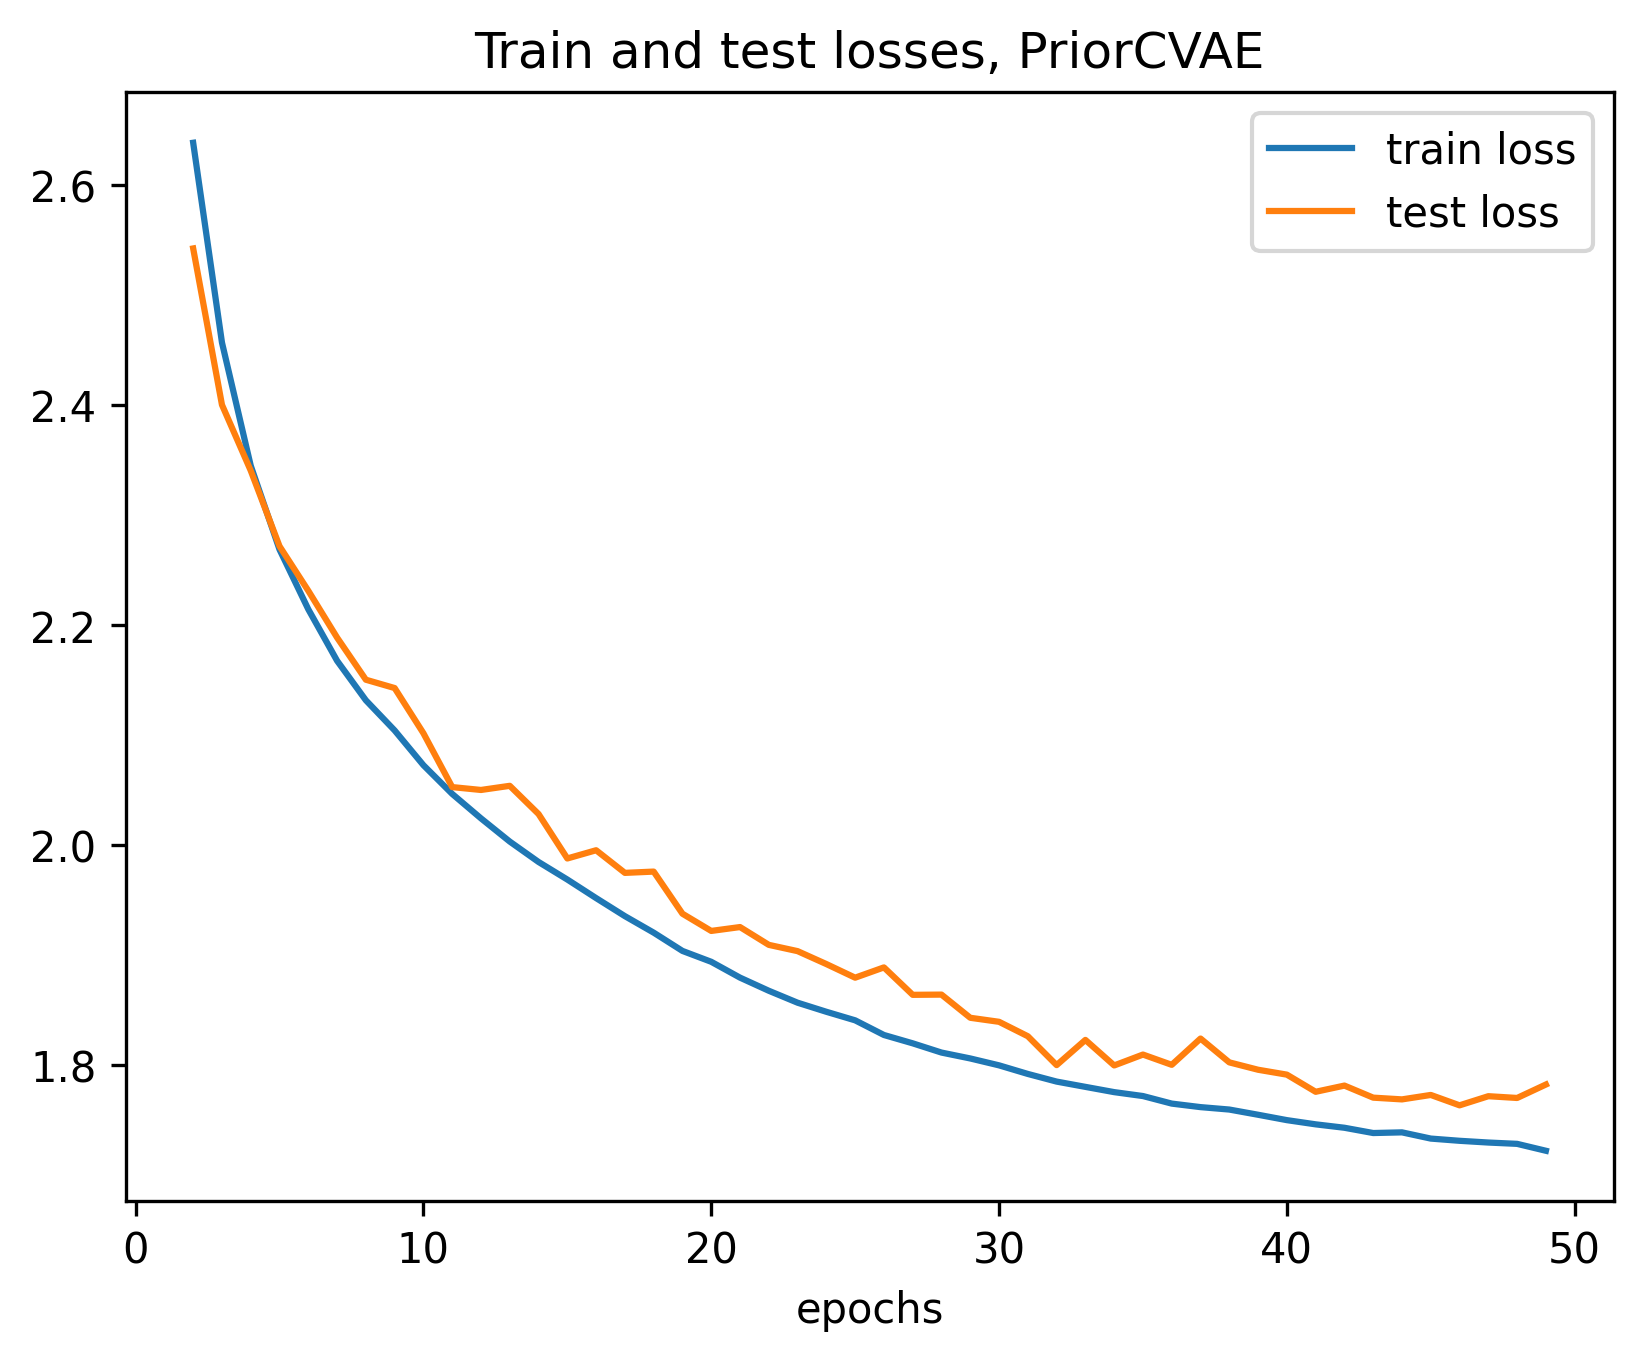

In [100]:
plt.plot(np.arange(2, len(train_losses_save), 1), train_losses_save[2:], label="train loss")
plt.plot(np.arange(2, len(val_losses_save), 1), val_losses_save[2:], label="test loss")
plt.xlabel("epochs")
plt.legend()
plt.title("Train and test losses, PriorCVAE")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_admin_2_aggCVAE_loss_short' + model_specs + '.pdf')

In [101]:
decode_dict = {'decoder': decoder_params}
decode_dict

{'decoder': {'Dense_0': {'bias': Array([-0.04463705,  0.21215215,  0.23017299,  0.07038758,  0.1028648 ,
           0.1233054 ,  0.3327071 ,  0.0228999 ,  0.23694444,  0.15459585,
          -0.03974207,  0.12189431,  0.21754514,  0.07885703,  0.12663075,
           0.07444303,  0.11540665,  0.11257247,  0.15677601, -0.00475888,
           0.26377067,  0.31164035,  0.29361495,  0.0413305 ,  0.12446196,
          -0.02866801, -0.03671894,  0.07328622,  0.1714128 , -0.01278085,
           0.29087576,  0.2607105 ,  0.36292365,  0.03815721,  0.08286075,
           0.28365037,  0.18879008,  0.08820428,  0.131363  ,  0.08351996,
           0.09875165,  0.011323  ,  0.16697407,  0.10710227,  0.25501895,
           0.17725451,  0.15727189,  0.13819382,  0.20958589,  0.1341365 ,
          -0.08837183,  0.20457748,  0.30857602,  0.12718481,  0.14723912,
           0.00536061,  0.0201165 , -0.0479464 ,  0.17463948,  0.33631617,
           0.11832418,  0.10970072,  0.20752797,  0.16320316,  0.14565

In [102]:
def vae_sample(args):

    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance

    # will have to change to match closer to reality
    var = numpyro.sample("var", dist.HalfNormal(1))
    ls = numpyro.sample("ls", dist.Beta(3, 7))
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    
    prior_cvae_sample = build_prior_cvae(s.shape[0])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)

In [103]:
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
vae_predictive = Predictive(vae_sample, num_samples=args['num_samples_posterior'])
vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

/home/scratch/selden/anaconda3/envs/aggCVAE/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


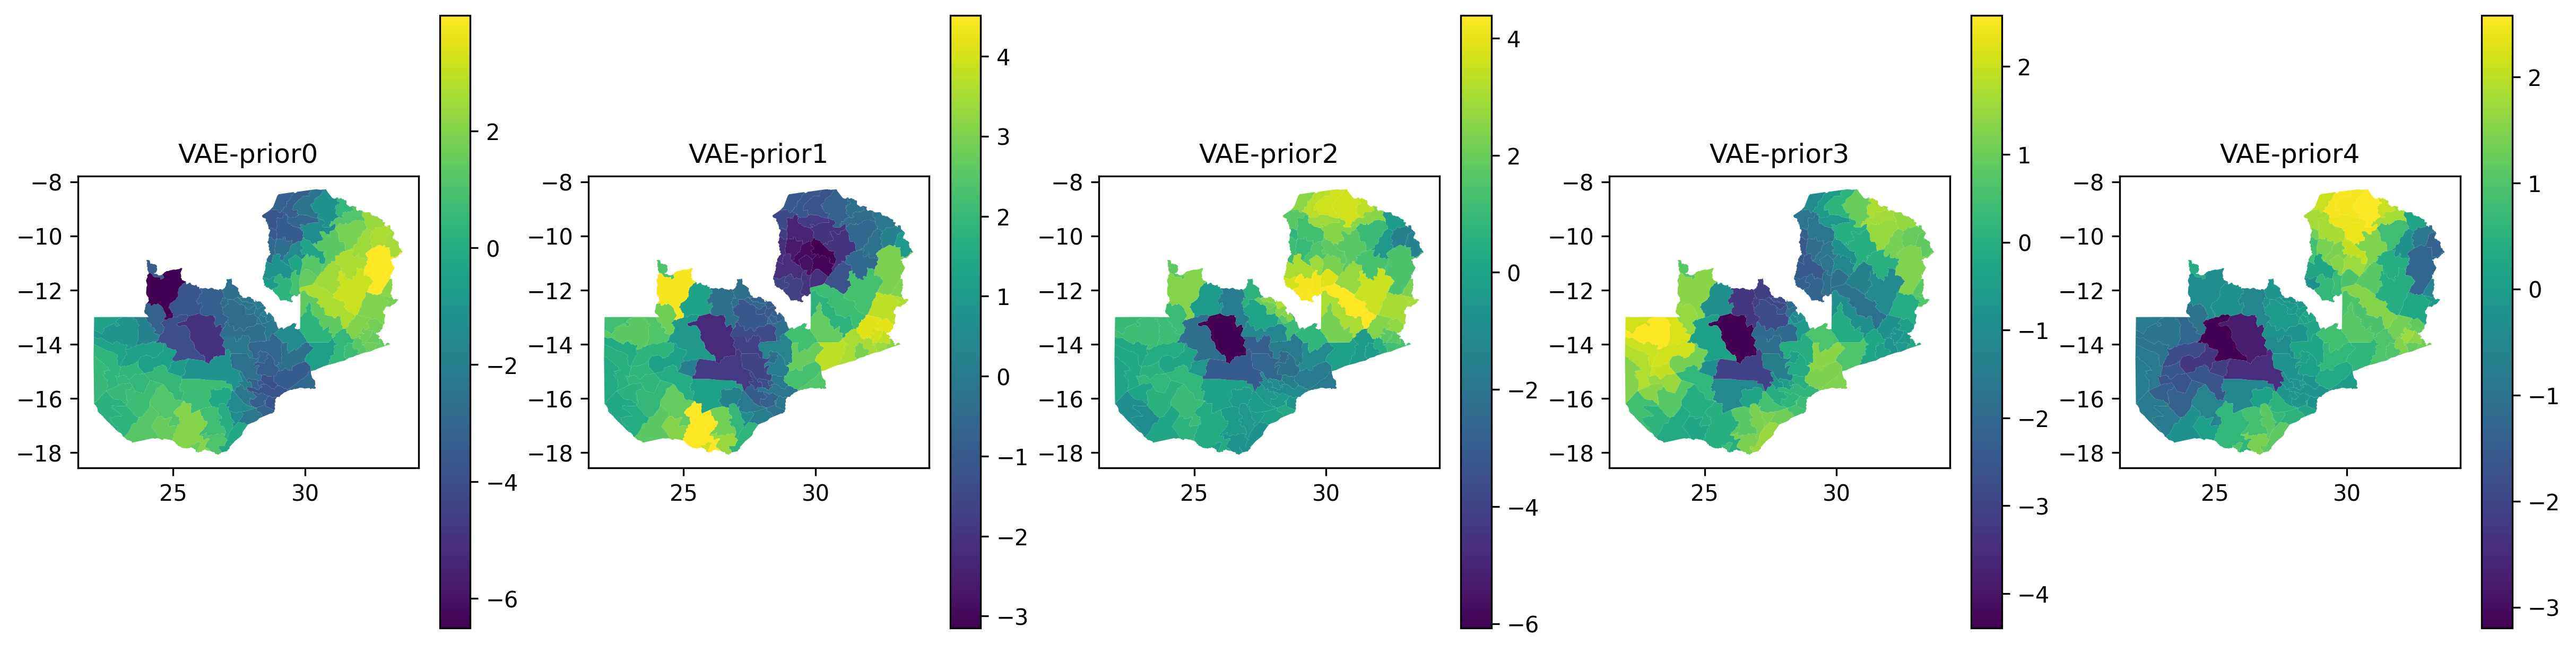

In [104]:
# new
fig, axs = plt.subplots(1, 5, figsize=(20, 5))


for i in range(5):
    nm = 'vae_draw_' + str(i)
    s_new_plot[nm] = vae_draws[i][0]
    s_new_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'VAE-prior' + str(i))

In [105]:
mean_vae_draws = jnp.mean(vae_draws, axis=0)
hpdi_vae_draws = hpdi(vae_draws, 0.95)
mean_gp_aggr = jnp.mean(agg_gp_draws, axis=0)
hpdi_gp_aggr = hpdi(agg_gp_draws,  0.95)

In [106]:
vae_draws.shape

(100, 1, 115)

In [107]:
mean_vae_draws.shape

(1, 115)

In [108]:
 mean_vae_draws[1][1:3]

Array([-0.01110612,  0.42456907], dtype=float32)

In [109]:
agg_gp_draws.shape

(100, 115)

In [110]:
mean_gp_aggr.shape

(115,)

In [111]:
s.shape[0]

115

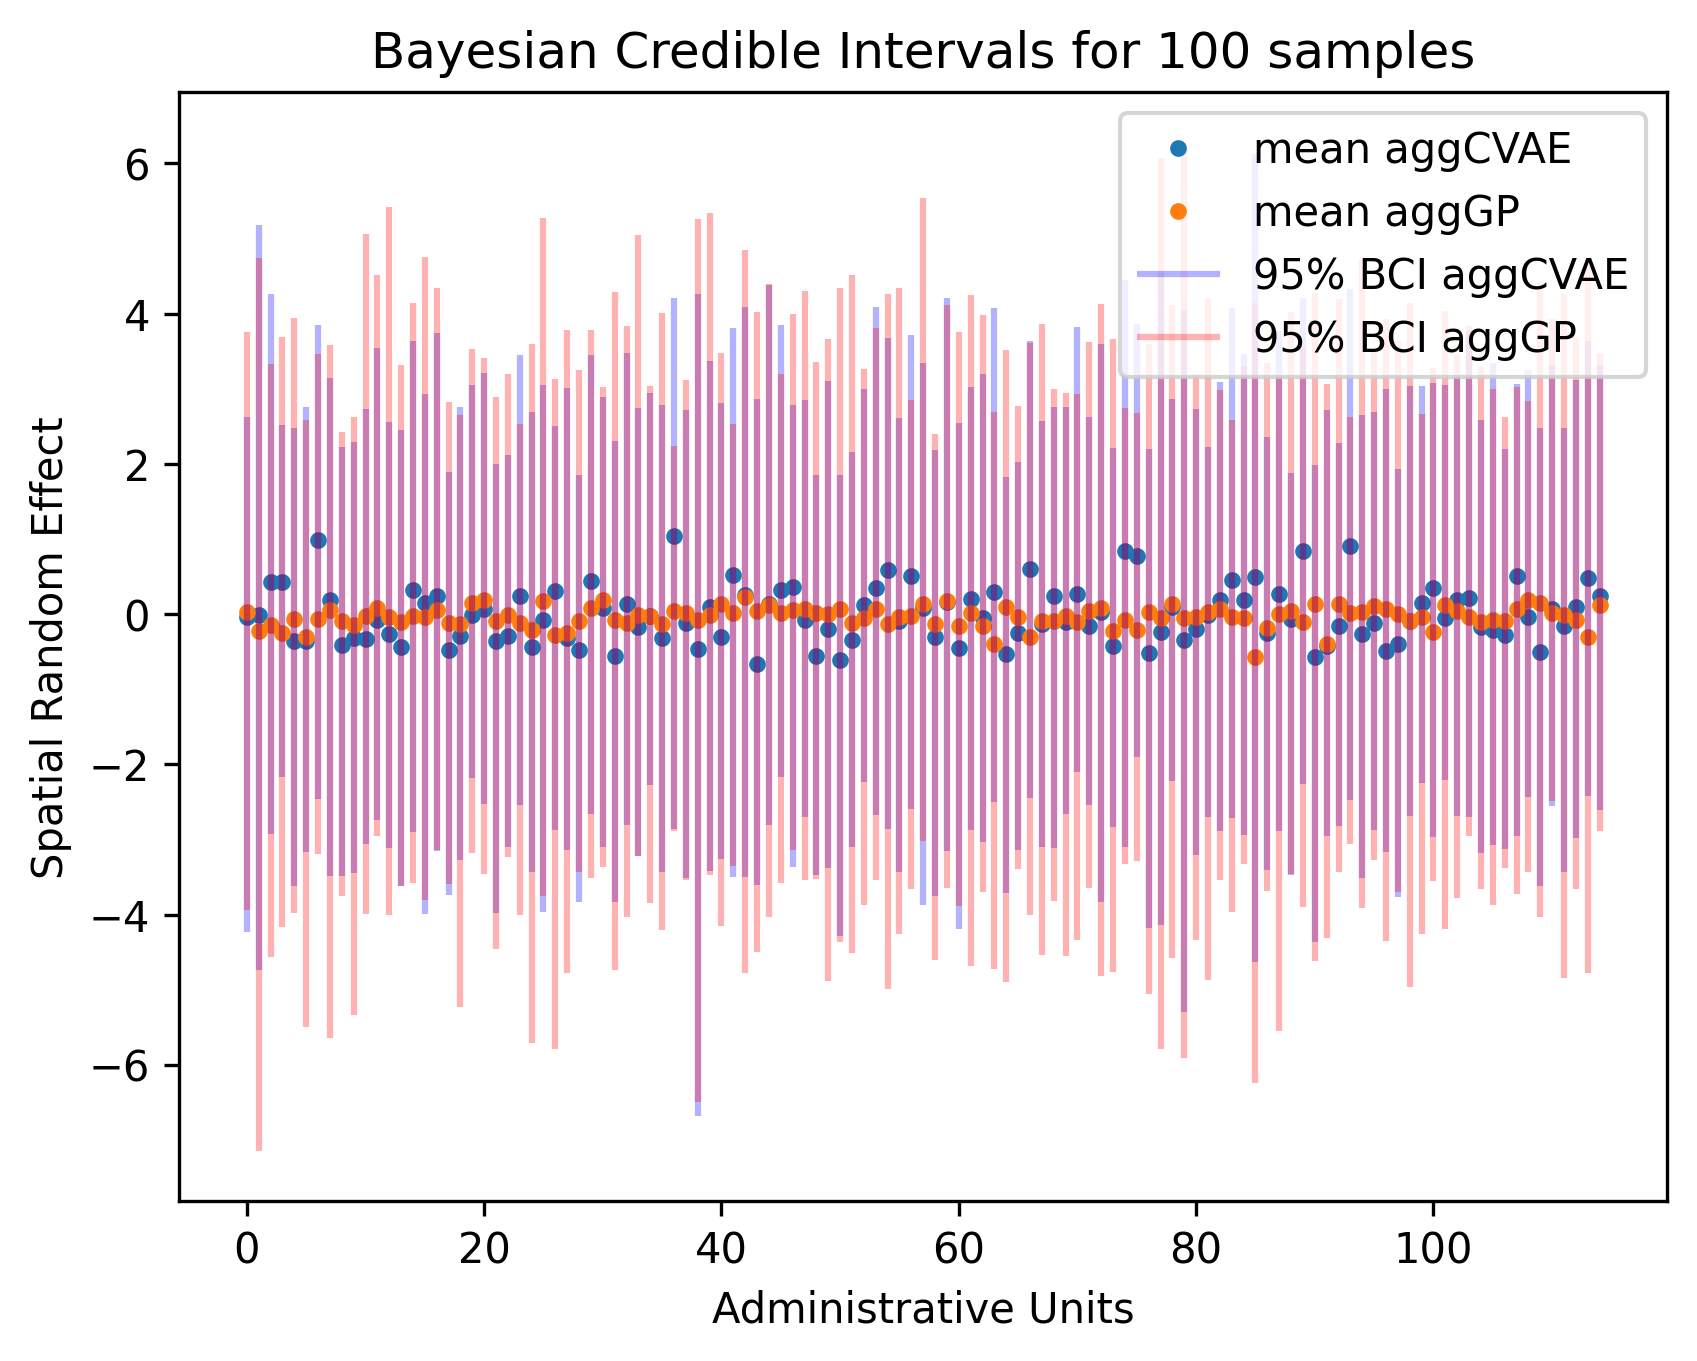

In [113]:
x = np.arange(0, s.shape[0], 1)
# y_mean = mean_gp_aggr
# y_hpdi = hpdi_gp_aggr[:,:n_old]
# data = agg_gp_draws[i, :n_old]

# Sort values for plotting by x axis
idx = jnp.argsort(x)
x_axis = x[idx]
mean_cvae = mean_vae_draws[1][idx]
mean_gp = mean_gp_aggr[idx]

hpdi_cvae = hpdi_vae_draws[:, :, idx]
hpdi_gp = hpdi_gp_aggr[:, idx]


# Plot
plt.plot(x_axis, mean_cvae, ".", label="mean aggCVAE")
plt.plot(x_axis, mean_gp, ".", label="mean aggGP")
plt.vlines(x_axis, ymin=hpdi_cvae[0][0], ymax=hpdi_cvae[1][0], colors="blue", alpha=0.3, label="95% BCI aggCVAE")
plt.vlines(x_axis, ymin=hpdi_gp[0], ymax=hpdi_gp[1], colors="red", alpha=0.3, label="95% BCI aggGP")
plt.legend()
plt.ylabel('Spatial Random Effect')
plt.xlabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for {args['num_samples_posterior']} samples')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_posterior_BCI'+ model_specs + '.pdf')

In [85]:
hpdi_cvae[0][0]

array([-1.5277587 , -1.5864617 , -2.3753247 , -1.991283  , -1.4922092 ,
       -1.3368232 , -2.1923647 , -1.3156298 , -1.2421621 , -2.7759888 ,
       -0.70587426, -1.4948088 , -0.98727536, -1.7493668 , -1.4575694 ,
       -1.0552595 , -0.4984314 , -2.3031619 , -1.8815879 , -1.0465065 ,
       -2.3614812 , -2.1016147 , -2.7991493 , -1.1403176 , -1.4365257 ,
       -2.750976  , -3.2357996 , -2.166944  , -1.3567497 , -5.322264  ,
       -3.7970552 , -1.2876621 , -1.7775098 , -1.1449016 , -0.80293286,
       -0.89708054, -0.847181  , -2.2702007 , -0.8432284 , -1.8378485 ,
       -2.5964625 , -1.3910321 , -1.3035163 , -0.6740848 , -2.0654664 ,
       -2.885839  , -5.227511  , -1.0689914 , -1.2965906 , -1.7350827 ,
       -4.083003  , -1.7198852 , -1.4619163 , -1.8291993 , -3.6793442 ,
       -0.9784699 , -1.2176741 , -2.4109476 , -1.5175873 , -1.9884299 ,
       -1.7387617 , -1.1902766 , -3.115839  , -1.4961284 , -1.2559978 ,
       -2.5437577 , -1.0051209 , -0.77640325, -1.9871699 , -1.80

## Prevalence model - VAE

In [116]:
# num_s is 10 for admin 1 because there are 10 polygons, i.e. the K in (B, K, 1)
if admin_level == 1:
    num_s = 10
if admin_level == 2:
    num_s  = 115

In [117]:
def prev_model_vae_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    
    # hyperparameters
    ls = numpyro.sample("kernel_length", args['hyperprior_ls'])
    var = numpyro.sample("kernel_var", args['hyperprior_var'])
    

    # random effect
    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    prior_cvae_sample = build_prior_cvae(num_s)
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)
    
    s = numpyro.sample("sigma", dist.HalfNormal(50))
    vae = numpyro.deterministic('vae', s * vae_aggr)
    # vae = numpyro.deterministic('vae', vae_aggr)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    lp = b0 + vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [118]:
run_mcmc = True

if run_mcmc:

    rng_key, rng_key_predict = random.split(random.PRNGKey(6))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_vae_aggr)
    mcmc_vae = MCMC(kernel, num_warmup=200, num_samples=1000)
    mcmc_vae.run(rng_key, args, y = jnp.array(s.y))
    t_elapsed = time.time() - start

    prev_samples = mcmc_vae.get_samples()
    mcmc_vae.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all aggVAE effects : " + str(round(r)))

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))

    # ess_old = np.mean(ss['vae_aggr']['n_eff'][0:n_old])
    # r_hat_old = np.max(ss['vae_aggr']['r_hat'][0:n_old])

    # ess_new = np.mean(ss['vae_aggr']['n_eff'][n_old:(n_old+n_new)])
    # r_hat_new = np.max(ss['vae_aggr']['r_hat'][n_old:(n_old+n_new)])

    ess_new = np.mean(ss['vae_aggr']['n_eff'])
    r_hat_new = np.max(ss['vae_aggr']['r_hat'])


    # print("Average ESS for all aggVAE-old effects : " + str(round(ess_old)))
    # print("Max r_hat for all aggVAE-old effects : " + str(round(r_hat_old,2)))

    print("Average ESS for all aggVAE-new effects : " + str(round(ess_new)))
    print("Max r_hat for all aggVAE-new effects : " + str(round(r_hat_new,2)))

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all VAE-CAR effects : " + str(round(r)))

sample:  59%|▌| 710/1200 [33:59<23:27,  2.87s/it, 127 steps of size 3.22e-02. acc. prob=0.8


KeyboardInterrupt: 

In [ ]:
# Text content
content = (
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all aggVAE effects: {round(r)}\n"
    f"Average ESS for all aggVAE-new effects: {round(ess_new)}\n"
    f"Max r_hat for all aggVAE-new effects: {round(r_hat_new, 2)}\n"
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all VAE-CAR effects: {round(r)}\n"
)

# LaTeX table content
latex_content = r"""
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all aggVAE effects & """ + f"{round(r)}" + r""" \\
\hline
Average ESS for all aggVAE-new effects & """ + f"{round(ess_new)}" + r""" \\
\hline
Max r\_hat for all aggVAE-new effects & """ + f"{round(r_hat_new, 2)}" + r""" \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all VAE-CAR effects & """ + f"{round(r)}" + r""" \\
\hline
\end{tabular}
\caption{Summary of MCMC Results}
\label{table:mcmc_summary}
\end{table}
"""

# Save the text content to a pickle file
text_file_name = f'mcmc_summary_text_aggCVAE_admin{admin_level}' + model_specs + '.pkl'
with open(text_file_name, 'wb') as text_file:
    pickle.dump(content, text_file)

# Save the LaTeX content to a separate pickle file
latex_file_name = f'mcmc_summary_latex_aggCVAE_admin{admin_level}' + model_specs + '.pkl'
with open(latex_file_name, 'wb') as latex_file:
    pickle.dump(latex_content, latex_file)

print(f"Text content has been saved to {text_file_name}")
print(f"LaTeX content has been saved to {latex_file_name}")

# To load the text content back from the pickle file (for verification)
with open(text_file_name, 'rb') as text_file:
    loaded_text_content = pickle.load(text_file)
    print("Loaded text content:")
    print(loaded_text_content)

# To load the LaTeX content back from the pickle file (for verification)
with open(latex_file_name, 'rb') as latex_file:
    loaded_latex_content = pickle.load(latex_file)
    print("Loaded LaTeX content:")
    print(loaded_latex_content)

In [ ]:
ls_samps = prev_samples['kernel_length']
plt.hist(ls_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('ls - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_ls_posterior_hist'+ model_specs + '.pdf')

In [ ]:
max(ls_samps)

In [ ]:
min(ls_samps)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ls_samps is defined as your list of samples
ls_samps = prev_samples['kernel_length']

# Create a density plot
sns.kdeplot(ls_samps, label='posterior samples', fill=True)

# Optionally, add a vertical line for the true length scale if needed
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')

plt.xlim(0, 1)
plt.title('ls - posterior samples')
plt.legend()

# Show the plot
plt.show()


In [ ]:
var_samps = prev_samples['kernel_var']
plt.hist(var_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('var - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_var_posterior_hist'+ model_specs + '.pdf')

In [ ]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
az.plot_trace(az_data, var_names=('kernel_length'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_ls_posterior_trace'+ model_specs + '.pdf')

In [ ]:
az.plot_trace(az_data, var_names=('kernel_var'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_var_posterior_trace'+ model_specs + '.pdf')

In [ ]:
# posterior predictive - 1
prev_posterior_predictive_vae = Predictive(prev_model_vae_aggr, prev_samples)(random.PRNGKey(1), args)

theta_samps_vae_aggr = prev_posterior_predictive_vae['theta']
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=0)
# transpose
theta_mean_vae_aggr = theta_mean_vae_aggr.transpose()
bci_vae_aggr_25 = np.quantile(theta_samps_vae_aggr, 0.25, axis=0)
bci_vae_aggr_75 = np.quantile(theta_samps_vae_aggr, 0.75, axis=0)

s['theta_vae_aggr'] = theta_mean_vae_aggr

theta_observed = s['estimate']
theta_estimated_vae_aggr = s['theta_vae_aggr']

_max = np.max([theta_observed, theta_estimated_vae_aggr])
_min = np.min([theta_observed, theta_estimated_vae_aggr])


# BCI for prevalence
percentiles_vae = np.percentile(theta_samps_vae_aggr, [5.0, 95.0], axis=0)

# have to change s.shape[0] to num_s if combining two different levels of administrative units
x_axis = np.arange(0, s.shape[0], 1)

plt.plot(x, theta_observed, ".", label="observed data")
plt.plot(x, theta_estimated_vae_aggr, ".", label="mean cvae")
plt.vlines(x_axis, ymin=percentiles_vae[0], ymax=percentiles_vae[1], colors="blue", alpha=0.3, label="95% BCI aggCVAE")
plt.legend()
plt.ylabel('Prevalence')
plt.xlabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for Estimated Prevalence')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_prevalence_BCI'+ model_specs + '.pdf')


In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[0:n_old].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

# ax[0].set_title( 'Before: Observed prevalence')
# ax[1].set_title( 'Before: Estimated prevalence (aggregated VAE)')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# s[n_old:(n_old + n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
# s[n_old:(n_old + n_new)].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (aggregated VAE)')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_prev_results'+ model_specs + '.pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# ax[0].scatter(s[0:n_old].estimate, s[0:n_old].theta_vae_aggr)
# ax[0].set_ylim(_min-0.02, _max+0.02)
# ax[0].set_xlim(_min-0.02, _max+0.02)
# ax[0].axline((1, 1), slope=1, ls="--", c=".3")
# ax[0].set_xlabel("Observed prevalence")
# ax[0].set_ylabel("Estimated prevalence")
# ax[0].set_title("Before 2010")

# ax[1].scatter(s[n_old:(n_old + n_new)].estimate, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax.scatter(s.estimate, s.theta_vae_aggr)
ax.set_ylim(_min-0.02, _max+0.02)
ax.set_xlim(_min-0.02, _max+0.02)
ax.axline((1, 1), slope=1, ls="--", c=".3")
ax.set_xlabel("Observed prevalence")
ax.set_ylabel("Estimated prevalence")
ax.set_title("Zambia 2018")

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/est_obs_vae.pdf')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_AggCVAE_admin{admin_level}_prev_results_scatterplot'+ model_specs + '.pdf')

In [ ]:
def prev_model_gp_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))

    # linear predictor
    lp = b0 + gp_aggr
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [ ]:
# Load
#with open('MCMCs/prev_model_gp_aggr_joint_500iter_lsIG3_3', 'rb') as file:
#    mcmc_gp_aggr = pickle.load(file)

#prev_samples_aggr = mcmc_gp_aggr.get_samples()
#mcmc_gp_aggr.print_summary(exclude_deterministic=False)

In [ ]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_gp_aggr, prev_samples_aggr)(random.PRNGKey(1), args)

theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp
theta_estimated_gp = s['theta_gp']

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(s[0:n_old].theta_gp, s[0:n_old].theta_vae_aggr)
ax[0].set_ylim(_min-0.02, _max+0.02)
ax[0].set_xlim(_min-0.02, _max+0.02)
ax[0].axline((1, 1), slope=1, ls="--", c=".3")
ax[0].set_xlabel("estimated prev (aggGP)")
ax[0].set_ylabel("estimated prev (aggVAE)")
ax[0].set_title("before 2010")

ax[1].scatter(s[n_old:(n_old + n_new)].theta_gp, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax[1].set_ylim(_min-0.02, _max+0.02)
ax[1].set_xlim(_min-0.02, _max+0.02)
ax[1].axline((1, 1), slope=1, ls="--", c=".3")
ax[1].set_xlabel("estimated prev (aggGP)")
ax[1].set_ylabel("estimated prev (aggVAE)")
ax[1].set_title("after 2010")

In [ ]:
# 1
_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Before: Observed prev')
ax[1].set_title( 'Before: Estimated prev (aggGP)')
ax[2].set_title( 'Before: Estimated prev (aggVAE)')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[n_old:(n_old+n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'After: Observed prev')
ax[1].set_title( 'After: Estimated prev (aggGP)')
ax[2].set_title( 'After: Estimated prev (aggVAE)')